# 2009 RECS electric consumption
The purpose of this notebook is to run some proof-of-concept models to better understand the relationship between housing characteristics and the electric consumption. The electric consumption is represented as the KWH (Kilowatt-hours) to determine the total site electricity usage. 

Data were collected from 12,083 households selected by a multistage and area-probability sampling, representing 113.6 million U.S. households, the Census Bureau’s statistical estimate for all occupied housing units in 2009 derived from their American Community Survey (ACS).

Data were stored into 2 main .csv files. The housing characteristics are in the 'recs2009_public.csv' while the 'public_layout.csv' contains descriptive labels and formats for each data variable.

## Table of Contents
1. [Data Acquisition](#DA) - Data source
2. [Exploratory Data Analysis](#EDA) - Insights of the key characteristics
3. [Feature Engineering](#FE) - Feature discovery
4. [Modelling](#M) - Model development
5. [Error Analysis](#EA) - Prediction interval
6. [Conclusion](#CN)
7. [Next Steps](#NS)

In [526]:
#Prerequisite libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import learning_curve
from sklearn.preprocessing import PowerTransformer
from sklearn.metrics import classification_report, confusion_matrix,ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor 
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error as mape

## 1. Data Acquisition <a class="anchor" id="DA"></a>

Housing characteristics and layout data are fetched from reading .csv files.

In [729]:
#Housing characteristics
data=pd.read_csv("recs2009_public.csv")

#Layout descriptions
layout=pd.read_csv("public_layout.csv")

Columns (717,718) have mixed types. Specify dtype option on import or set low_memory=False.


In [730]:
#Data frame of housing characteristics 
data

,DOEID,REGIONC,DIVISION,REPORTABLE_DOMAIN,TYPEHUQ,NWEIGHT,HDD65,CDD65,HDD30YR,CDD30YR,...,SCALEKER,IECC_Climate_Pub,HDD50,CDD80,GND_HDD65,WSF,OA_LAT,GWT,DesignDBT99,DesignDBT1
0,1,2,4,12,2,2471.68,4742,1080,4953,1271,...,-2,4A,2117,56,4250,0.48,6,56,9,96
1,2,4,10,26,2,8599.17,2662,199,2688,143,...,-2,3C,62,26,2393,0.61,0,64,38,73
2,3,1,1,1,5,8969.92,6233,505,5741,829,...,-2,5A,2346,49,5654,0.48,3,52,12,88
3,4,2,3,7,2,18003.64,6034,672,5781,868,...,-2,5A,2746,0,4941,0.55,4,55,7,87
4,5,1,1,1,3,5999.61,5388,702,5313,797,...,-2,5A,2251,0,5426,0.61,4,50,13,90
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12078,12079,2,3,9,2,10219.80,7671,332,7784,451,...,-2,6A-6B,4289,39,7819,0.59,0,48,-3,84
12079,12080,3,7,21,4,8689.07,2085,2844,2520,2286,...,-2,3B-4B,360,393,1869,0.50,0,56,26,101
12080,12081,2,4,10,2,4697.21,7935,472,8074,600,...,-2,6A-6B,4494,22,8477,0.58,1,46,-9,89
12081,12082,4,8,23,2,13155.68,5834,770,5989,957,...,-2,5B-5C,2840,0,9010,0.54,1,53,13,93


In [731]:
#Data frame of layout descriptions
layout

,Variable Name,Variable Label,Variable Order in File,Variable Type,Length
0,DOEID,Unique identifier for each respondent,1,Character,5
1,REGIONC,Census Region,2,Numeric,8
2,DIVISION,Census Division,3,Numeric,8
3,REPORTABLE_DOMAIN,Reportable states and groups of states,4,Numeric,8
4,TYPEHUQ,Type of housing unit,5,Numeric,8
...,...,...,...,...,...
935,WSF,Weather & shielding factor for the housing unit,936,Numeric,8
936,OA_LAT,Annual value for latent heat infiltration from...,937,Numeric,8
937,GWT,Annual average ground water temperature (F) fo...,938,Numeric,8
938,DesignDBT99,Dry bulb design temperature (F) expected to be...,939,Numeric,8


## 2. Exploratory Data Analysis <a class="anchor" id="EDA"></a>
### 2.1 Data information
Understanding the given dataset and helps clean up the dataset.

In [732]:
#Knowing the general information about the data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12083 entries, 0 to 12082
Columns: 940 entries, DOEID to DesignDBT1
dtypes: float64(50), int64(885), object(5)
memory usage: 86.7+ MB


In [733]:
#Knowing data types of housing characteristics
layout['Variable Type'].value_counts()

Numeric      930
Character     10
Name: Variable Type, dtype: int64

From the result of data information and the layout descriptions, we know that there are 5 object features and 10 character features. Considering that the object is a form of data type representing any value type (numeric, boolean, char, data ,structure or enumeration), we would like to further investigate how many categorical features there are in the data frame.

### 2.2 Categorical Variables
Finding categorical variables that need to be one-hot encoded in the future.

In [734]:
categorical=[]

#Finding character variables in the data frame
for i in layout[layout['Variable Type']=='Character']['Variable Name']:
    categorical.append(i)

In [735]:
#Ctegorical variables
categorical

['DOEID',
 'METROMICRO',
 'UR',
 'ZTOTSQFT',
 'ZTOTSQFT_EN',
 'ZTOTHSQFT',
 'ZTOTUSQFT',
 'ZTOTCSQFT',
 'ZTOTUCSQFT',
 'IECC_Climate_Pub']

In [736]:
#An example of categorical variable
data['UR'].value_counts()

U    9656
R    2427
Name: UR, dtype: int64

### 2.3 Missing values
Detecting missing values in the dataframe in order to avoid bias or the loss of accuracy.

In [737]:
#Checking if there are null/missing values in the data frame
data.isnull().sum().value_counts()

0    940
dtype: int64

There are 0 null values in all 940 features.

### 2.4 Target label
After that, we have to take a look at the specific goal, namely KWH to make sure it is not skewed.

In [738]:
#Basic statistics of KWH
data['KWH'].describe()

count     12083.000000
mean      11288.159398
std        7641.190845
min          17.000000
25%        5837.000000
50%        9623.000000
75%       14765.000000
max      150254.000000
Name: KWH, dtype: float64

Text(0.5, 1.0, 'Distribution of KWH')

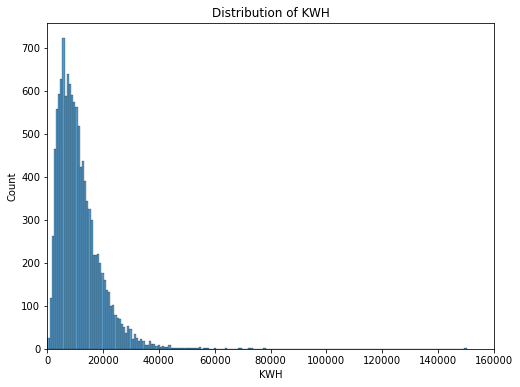

In [739]:
#The distribution plot of KWH
fig,ax=plt.subplots(figsize=(8,6))
ax.set_xlim(0,160000)
sns.histplot(data['KWH'],ax=ax).set_title('Distribution of KWH')

It is clear in the plot that the distribution of KWH is not normally distributed but positive skewed. Also, the high standard deviation proves that data are far from the mean. We will address this issue in the follwing section.

## 3. Feature Engineering <a class="anchor" id="FE"></a>

A variaty of pre-processing steps on dealing with features to improve the performance of models.

### 3.1 One-hot encoding
One-hot encoding for those categorical variables.

In [740]:
#Label factorization for those 'object' features
for i in data.columns[data.dtypes=='O']:
    #print(i)
    data[i]=data[i].factorize()[0]

In [741]:
#Removal of the unrelated primary key feature 'DOEID'
categorical.remove('DOEID')

In [742]:
#One-hot encoding for each categorical variables
for i in categorical:
    
    #Renameing variables to avoid repetition and ambiguity
    one_hot=pd.get_dummies(data[i]).rename(columns=lambda x:i+'_'+str(x))
    
    #Removal of the last one-hot column to avoid multicollinearity
    one_hot=one_hot.iloc[:,:-1]
    data=data.drop(columns=i)
    data=data.join(one_hot)

### 3.2 Correlation coefficient
A high correlation coefficient would lead to a chance that the performance of the model will be impacted by the multicollinearity.

In [743]:
#Finding the strongest correlated variable with KWH
corr_coef=data.corr()
corr_feat=corr_coef["KWH"].copy()
corr_feat=corr_feat.sort_values(ascending=False)
corr_feat.index[1]

'BTUEL'

In [542]:
#Dropping the highly correlated feature
data=data.drop(columns=['BTUEL'])

### 3.3 Outlier removal
Outliers are those data points which differs significantly from other observations present in given dataset. It can occur because of variability in measurement and due to misinterpretation in filling data points.

One of the simplest methods for detecting outliers is box plots. A box plot is a graphical display for describing the distributions of the data. Box plots use the median and the lower and upper quartiles. 

Text(0.5, 0, 'feature')

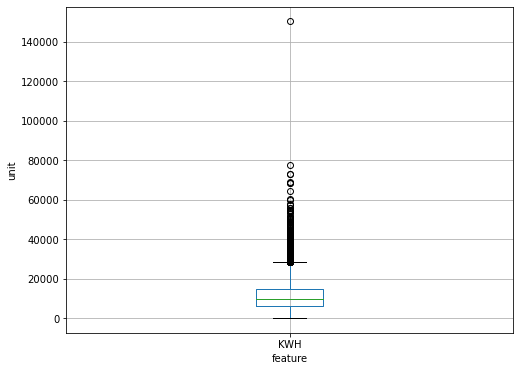

In [543]:
#Box plot of KWH
boxplot=data.boxplot(column=['KWH'],figsize=(8,6))
boxplot.set_ylabel('unit')
boxplot.set_xlabel('feature')

As is shown in the box plot, most of the data points are from 0 to 80,000. There is a noticeable outlier which exceeds 140,000. So we have to remove this outlier which may have a detrimental effect on our model performance. 

In [544]:
#Remove the data point whose KWH is greater than 80,000
remove=data.loc[data['KWH']>80000].index

In [545]:
data=data.drop(remove)

After that, we still can expect the distribution of KWH is postive skewed since we only removed 1 data point. In this case, we can take the logarithm of the KWH to make it normally distributed as much as possible.

In [546]:
#The Logarithm of KWN
data['KWH']=np.log10(data['KWH'])

In [547]:
#Basic statistics of KWH after the logarithm
data['KWH'].describe()

count    12082.000000
mean         3.957331
std          0.302614
min          1.230449
25%          3.766152
50%          3.983265
75%          4.169138
max          4.889985
Name: KWH, dtype: float64

Text(0.5, 1.0, 'Distribution of log KWH')

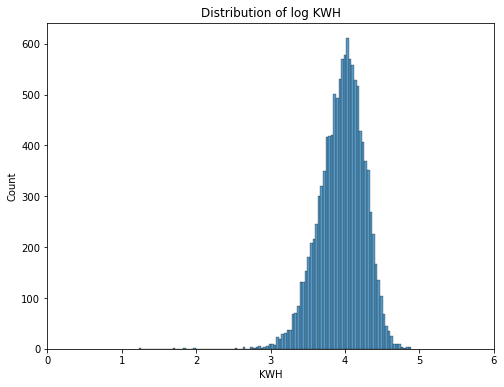

In [548]:
#The distribution plot of KWH after the logarithm
fig,ax=plt.subplots(figsize=[8,6])
ax.set_xlim(0,6)
sns.histplot(data['KWH'],ax=ax).set_title('Distribution of log KWH')

## 4. Modelling <a class="anchor" id="M"></a>

We try out Random Forest, Xgboost and deep learning algorithms on predicting the KWH.

In [549]:
#Input of data
X=data.drop(columns=['DOEID','KWH'])

#Output of data
y=data['KWH']

In [550]:
#Data normalization
Scaler=StandardScaler()
X_=Scaler.fit_transform(X)

In [551]:
#75% of training and 25% of testing
X_train,X_test,y_train,y_test=train_test_split(X_,y,test_size=0.25,random_state=0)

In [552]:
#Before normalization()
X_train1,X_test1,y_train1,y_test1=train_test_split(X,y,test_size=0.25,random_state=0)

### 4.1 Random Forest
The reason why we choose random forest is that it is flexible to apply to regression problems and convenient to improve the model performance.

In [553]:
rd_regressor=RandomForestRegressor(random_state=100,n_jobs=-1,verbose=True)
rd_regressor.fit(X_train,y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   11.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   30.2s finished


RandomForestRegressor(n_jobs=-1, random_state=100, verbose=True)

In [554]:
rd_regressor_train_preds =rd_regressor.predict(X_train)
rd_regressor_preds=rd_regressor.predict(X_test)

model_train_mae=mean_absolute_error(y_train,rd_regressor_train_preds)
model_mae=mean_absolute_error(y_test,rd_regressor_preds)

print(f"Model train mae={model_train_mae},test mae ={model_mae}")

Model train mae=0.008361382608794671,test mae =0.022224656384556566


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


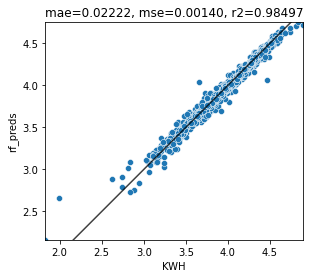

mae=0.022224656384556566
mse=0.0014042226471768782
r2_score=0.9849664688242586


In [556]:
sns.scatterplot(x=y_test, y=rd_regressor_preds) 

ax=plt.gca()
ax.set_aspect('equal')
ax.set_xlim([min(y_test),max(y_test)])
ax.set_ylim([min(rd_regressor_preds),max(rd_regressor_preds)])
lims=[
    np.min([ax.get_xlim(),ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(),ax.get_ylim()]),  # max of both axes
]

ax.plot(lims,lims,'k-',alpha=0.75,zorder=2)
# plt.axhline(y=0, color='r', linestyle='-')
plt.ylabel('rf_preds')
plt.title(f"mae={model_mae:.5f}, " +
          f"mse={mean_squared_error(y_test,rd_regressor_preds):.5f}, " +
          f"r2={r2_score(y_test,rd_regressor_preds):.5f}")

plt.show() 

print(f"mae={model_mae}")
print(f"mse={mean_squared_error(y_test,rd_regressor_preds)}")
print(f"r2_score={r2_score(y_test,rd_regressor_preds)}")

We can also output the important features for further modelling:

In [557]:
#Important features in the RF model
imp_dict={'Feature':X_train1.columns.to_list(),'Importance':rd_regressor.feature_importances_}
df_imp_dict=pd.DataFrame(imp_dict).sort_values(by='Importance',ascending=False).set_index('Feature')

In [558]:
df_imp_dict.head(10)

,Importance
Feature,
DOLLAREL,0.713128
BTUELOTH,0.083552
KWHOTH,0.071706
REPORTABLE_DOMAIN,0.029565
BTUELSPH,0.009892
KWHSPH,0.009847
TOTALBTU,0.008562
FUELHEAT,0.008203
KWHWTH,0.007287


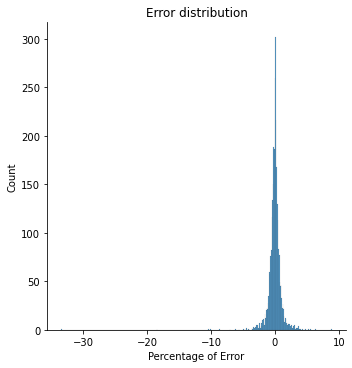

In [639]:
#Percentage error for actual vs predicted value
preds_percent_diff=(y_test-rd_regressor_preds).div(y_test,axis=0)*100
sns.displot(preds_percent_diff)
plt.xlabel("Percentage of Error")
plt.title('Error distribution')
plt.show()

In [563]:
preds_percent_diff.sum()

-78.33854357510765

### 4.2 Xgboost
Xgboost is a good option for unbalanced datasets and always gives more importance to functional space when reducing the cost of a model.

In [564]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [565]:
import xgboost as xgb

dtrain=xgb.DMatrix(X_train,label=y_train)
dtest=xgb.DMatrix(X_test,label=y_test)
num_boost_round = 999

params={'max_depth': 6,
 'min_child_weight': 1,
 'eta': .3,
 'subsample': 1.0,
 'colsample_bytree': 1.0,
 'objective': 'reg:squarederror'}

model=xgb.train(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    evals=[(dtest, "Test")],
    early_stopping_rounds=10
)

[0]	Test-rmse:2.43335
[1]	Test-rmse:1.70569
[2]	Test-rmse:1.19531
[3]	Test-rmse:0.83873
[4]	Test-rmse:0.58909
[5]	Test-rmse:0.41468
[6]	Test-rmse:0.29253
[7]	Test-rmse:0.20748
[8]	Test-rmse:0.14888
[9]	Test-rmse:0.10908
[10]	Test-rmse:0.08225
[11]	Test-rmse:0.06460
[12]	Test-rmse:0.05369
[13]	Test-rmse:0.04728
[14]	Test-rmse:0.04320
[15]	Test-rmse:0.04093
[16]	Test-rmse:0.03922
[17]	Test-rmse:0.03816
[18]	Test-rmse:0.03738
[19]	Test-rmse:0.03651
[20]	Test-rmse:0.03594
[21]	Test-rmse:0.03523
[22]	Test-rmse:0.03470
[23]	Test-rmse:0.03428
[24]	Test-rmse:0.03406
[25]	Test-rmse:0.03374
[26]	Test-rmse:0.03353
[27]	Test-rmse:0.03324
[28]	Test-rmse:0.03308
[29]	Test-rmse:0.03277
[30]	Test-rmse:0.03239
[31]	Test-rmse:0.03223
[32]	Test-rmse:0.03198
[33]	Test-rmse:0.03185
[34]	Test-rmse:0.03167
[35]	Test-rmse:0.03152
[36]	Test-rmse:0.03152
[37]	Test-rmse:0.03143
[38]	Test-rmse:0.03128
[39]	Test-rmse:0.03125
[40]	Test-rmse:0.03120
[41]	Test-rmse:0.03115
[42]	Test-rmse:0.03115
[43]	Test-rmse:0.0310

In [566]:
# Define initial best params and MAE
min_mae = float("Inf")
best_params = None
gridsearch_params = [
    (max_depth, min_child_weight)
    for max_depth in range(9,12)
    for min_child_weight in range(5,8)
]

for max_depth, min_child_weight in gridsearch_params:
    print("CV with max_depth={}, min_child_weight={}".format(
                             max_depth,
                             min_child_weight))
    # Update our parameters
    params['max_depth'] = max_depth
    params['min_child_weight'] = min_child_weight
    # Run CV
    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round=num_boost_round,
        seed=42,
        nfold=5,
        metrics={'mae'},
        early_stopping_rounds=10
    )
    # Update best MAE
    mean_mae = cv_results['test-mae-mean'].min()
    boost_rounds = cv_results['test-mae-mean'].argmin()
    print("\tMAE {} for {} rounds".format(mean_mae, boost_rounds))
    if mean_mae < min_mae:
        min_mae = mean_mae
        best_params = (max_depth,min_child_weight)
print("Best params: {}, {}, MAE: {}".format(best_params[0], best_params[1], min_mae))

CV with max_depth=9, min_child_weight=5
	MAE 0.019892096686442384 for 100 rounds
CV with max_depth=9, min_child_weight=6
	MAE 0.019669086556352366 for 119 rounds
CV with max_depth=9, min_child_weight=7
	MAE 0.01954456401858232 for 123 rounds
CV with max_depth=10, min_child_weight=5
	MAE 0.020189758373972348 for 99 rounds
CV with max_depth=10, min_child_weight=6
	MAE 0.020232972153200496 for 139 rounds
CV with max_depth=10, min_child_weight=7
	MAE 0.020015850972849657 for 143 rounds
CV with max_depth=11, min_child_weight=5
	MAE 0.02074791719261418 for 135 rounds
CV with max_depth=11, min_child_weight=6
	MAE 0.02058932747779326 for 175 rounds
CV with max_depth=11, min_child_weight=7
	MAE 0.020298423131216683 for 113 rounds
Best params: 9, 7, MAE: 0.01954456401858232


In [567]:
params['max_depth'] = 9
params['min_child_weight'] = 7

In [568]:
gridsearch_params = [
    (subsample, colsample)
    for subsample in [i/10. for i in range(7,11)]
    for colsample in [i/10. for i in range(7,11)]
]

min_mae = float("Inf")
best_params = None
# We start by the largest values and go down to the smallest
for subsample, colsample in reversed(gridsearch_params):
    print("CV with subsample={}, colsample={}".format(
                             subsample,
                             colsample))
    # We update our parameters
    params['subsample'] = subsample
    params['colsample_bytree'] = colsample
    # Run CV
    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round=num_boost_round,
        seed=42,
        nfold=5,
        metrics={'mae'},
        early_stopping_rounds=10
    )
    # Update best score
    mean_mae = cv_results['test-mae-mean'].min()
    boost_rounds = cv_results['test-mae-mean'].argmin()
    print("\tMAE {} for {} rounds".format(mean_mae, boost_rounds))
    if mean_mae < min_mae:
        min_mae = mean_mae
        best_params = (subsample,colsample)
print("Best params: {}, {}, MAE: {}".format(best_params[0], best_params[1], min_mae))

CV with subsample=1.0, colsample=1.0
	MAE 0.01954456401858232 for 123 rounds
CV with subsample=1.0, colsample=0.9
	MAE 0.019837590016805413 for 166 rounds
CV with subsample=1.0, colsample=0.8
	MAE 0.019051365094313776 for 178 rounds
CV with subsample=1.0, colsample=0.7
	MAE 0.01919891405515695 for 182 rounds
CV with subsample=0.9, colsample=1.0
	MAE 0.019964981602922587 for 96 rounds
CV with subsample=0.9, colsample=0.9
	MAE 0.019716854015236575 for 104 rounds
CV with subsample=0.9, colsample=0.8
	MAE 0.019416221904935842 for 151 rounds
CV with subsample=0.9, colsample=0.7
	MAE 0.019419187374518237 for 125 rounds
CV with subsample=0.8, colsample=1.0
	MAE 0.02046688765125885 for 95 rounds
CV with subsample=0.8, colsample=0.9
	MAE 0.019952856721167218 for 91 rounds
CV with subsample=0.8, colsample=0.8
	MAE 0.01983800108523206 for 143 rounds
CV with subsample=0.8, colsample=0.7
	MAE 0.019380743186073055 for 106 rounds
CV with subsample=0.7, colsample=1.0
	MAE 0.020455227871450894 for 99 r

In [569]:
params['subsample'] = 1
params['colsample_bytree'] = 0.8

In [570]:
min_mae = float("Inf")
best_params = None
for eta in [.3, .2, .1, .05, .01, .005]:
    print("CV with eta={}".format(eta))
    # We update our parameters
    params['eta'] = eta
    # Run and time CV
    %time cv_results = xgb.cv(params,dtrain,num_boost_round=num_boost_round,seed=42,nfold=5,metrics=['mae'],early_stopping_rounds=10)
    # Update best score
    mean_mae = cv_results['test-mae-mean'].min()
    boost_rounds = cv_results['test-mae-mean'].argmin()
    print("\tMAE {} for {} rounds\n".format(mean_mae, boost_rounds))
    if mean_mae < min_mae:
        min_mae = mean_mae
        best_params = eta
print("Best params: {}, MAE: {}".format(best_params, min_mae))

CV with eta=0.3
CPU times: total: 14min 56s
Wall time: 1min 53s
	MAE 0.019051365094313776 for 178 rounds

CV with eta=0.2
CPU times: total: 25min 32s
Wall time: 3min 15s
	MAE 0.016212150158007147 for 309 rounds

CV with eta=0.1
CPU times: total: 52min 18s
Wall time: 6min 36s
	MAE 0.012967734185824026 for 607 rounds

CV with eta=0.05
CPU times: total: 1h 25min 2s
Wall time: 10min 46s
	MAE 0.011418452880671816 for 998 rounds

CV with eta=0.01
CPU times: total: 1h 21min 43s
Wall time: 10min 23s
	MAE 0.012706717245810618 for 998 rounds

CV with eta=0.005
CPU times: total: 1h 15min 24s
Wall time: 9min 33s
	MAE 0.027497034361677518 for 998 rounds

Best params: 0.05, MAE: 0.011418452880671816


In [571]:
params['eta'] = .05

In [572]:
params

{'max_depth': 9,
 'min_child_weight': 7,
 'eta': 0.05,
 'subsample': 1,
 'colsample_bytree': 0.8,
 'objective': 'reg:squarederror'}

In [573]:
model = xgb.train(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    evals=[(dtest, "Test")],
    early_stopping_rounds=10
)

[0]	Test-rmse:3.30027
[1]	Test-rmse:3.13552
[2]	Test-rmse:2.97911
[3]	Test-rmse:2.83039
[4]	Test-rmse:2.68921
[5]	Test-rmse:2.55504
[6]	Test-rmse:2.42769
[7]	Test-rmse:2.30667
[8]	Test-rmse:2.19167
[9]	Test-rmse:2.08240
[10]	Test-rmse:1.97874
[11]	Test-rmse:1.88010
[12]	Test-rmse:1.78641
[13]	Test-rmse:1.69747
[14]	Test-rmse:1.61287
[15]	Test-rmse:1.53256
[16]	Test-rmse:1.45626
[17]	Test-rmse:1.38371
[18]	Test-rmse:1.31475
[19]	Test-rmse:1.24922
[20]	Test-rmse:1.18707
[21]	Test-rmse:1.12802
[22]	Test-rmse:1.07183
[23]	Test-rmse:1.01847
[24]	Test-rmse:0.96778
[25]	Test-rmse:0.91960
[26]	Test-rmse:0.87387
[27]	Test-rmse:0.83045
[28]	Test-rmse:0.78915
[29]	Test-rmse:0.74996
[30]	Test-rmse:0.71274
[31]	Test-rmse:0.67734
[32]	Test-rmse:0.64375
[33]	Test-rmse:0.61185
[34]	Test-rmse:0.58153
[35]	Test-rmse:0.55274
[36]	Test-rmse:0.52532
[37]	Test-rmse:0.49933
[38]	Test-rmse:0.47461
[39]	Test-rmse:0.45117
[40]	Test-rmse:0.42888
[41]	Test-rmse:0.40771
[42]	Test-rmse:0.38761
[43]	Test-rmse:0.3685

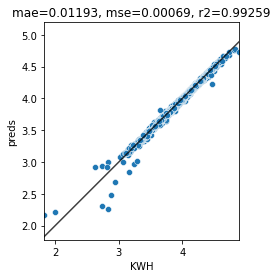

mae = 0.01192536713706093
mse = 0.000692593774013083
r2_score = 0.992585128779483


In [574]:
y_preds1=model.predict(dtest)
model_mae1=mean_absolute_error(y_test,y_preds1)
sns.scatterplot(x=y_test, y=y_preds1) 

ax1 = plt.gca()
ax1.set_aspect('equal')
ax1.set_xlim([min(y_test), max(y_test)])
ax1.set_ylim([min(y_preds), max(y_preds)])
lims1 = [
    np.min([ax1.get_xlim(), ax1.get_ylim()]),  # min of both axes
    np.max([ax1.get_xlim(), ax1.get_ylim()]),  # max of both axes
]

ax1.plot(lims1, lims1, 'k-', alpha=0.75, zorder=2)
# plt.axhline(y=0, color='r', linestyle='-')
plt.ylabel('preds')
plt.title(f"mae={model_mae1:.5f}, " +
          f"mse={mean_squared_error(y_test, y_preds1):.5f}, " +
          f"r2={r2_score(y_test, y_preds1):.5f}")

plt.show() 

print(f"mae = {model_mae1}")
print(f"mse = {mean_squared_error(y_test, y_preds1)}")
print(f"r2_score = {r2_score(y_test, y_preds1)}")

In [609]:
feature_important = model.get_score(importance_type='gain')
keys = list(feature_important.keys())
values = list(feature_important.values())

feat_index=[]
for i in keys:
    feat_index.append(int(i[1:]))
    
feat_name=[]
for i in feat_index:
    feat_name.append(X_train1.columns[i])
    
features = pd.DataFrame(data=values, index=feat_name, columns=["score"]).sort_values(by = "score", ascending=False)
features.head(10)

,score
DOLLAREL,1.847127
BTUELOTH,1.323407
KWHOTH,1.283221
FUELHEAT,0.535871
KWHWTH,0.349578
BTUELWTH,0.241903
KWHSPH,0.196582
KWHCOL,0.142449
TOTALBTUCOL,0.133344
BTUELSPH,0.129137


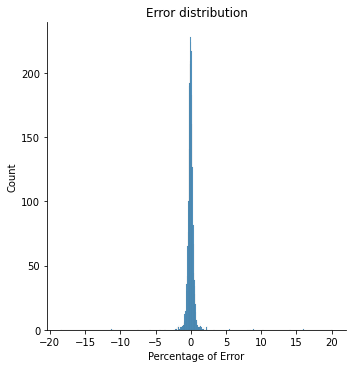

In [640]:
#Percentage error for actual vs predicted value
preds_percent_diff1 = (y_test - y_preds1).div(y_test, axis=0)*100
sns.displot(preds_percent_diff1)
plt.xlabel("Percentage of Error")
plt.title('Error distribution')
plt.show()

In [611]:
preds_percent_diff1.sum()

-18.28297181142649

### 4.3 Deep learning
Since we reach the performance bottle neck, we try the deep learning to see if it can improve the model performance.

In [466]:
pip install tensorflow

  Created wheel for termcolor: filename=termcolor-1.1.0-py3-none-any.whl size=4848 sha256=9babd8dc7a04b75d775c126f0dc6a1d559c0ff8c85adcbcf2bb950c587688323
  Stored in directory: c:\users\intwe\appdata\local\pip\cache\wheels\b6\0d\90\0d1bbd99855f99cb2f6c2e5ff96f8023fad8ec367695f7d72d
Successfully built termcolor
Note: you may need to restart the kernel to use updated packages.


In [612]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [634]:
model_deep=keras.Sequential()
model_deep.add(layers.Dense(512, activation="relu"))
model_deep.add(layers.Dense(128, activation="relu"))
model_deep.add(layers.Dense(64, activation="relu"))
model_deep.add(layers.Dense(1))
model_deep.compile(loss=keras.losses.mean_squared_error,optimizer=keras.optimizers.RMSprop(0.001))
history=model_deep.fit(X_train,y_train,batch_size=32,epochs=20)

Epoch 1/20
284/284 [==============================] - 3s 7ms/step - loss: 0.5605
Epoch 2/20
284/284 [==============================] - 2s 7ms/step - loss: 0.2417
Epoch 3/20
284/284 [==============================] - 2s 7ms/step - loss: 0.1396
Epoch 4/20
284/284 [==============================] - 2s 7ms/step - loss: 0.1257
Epoch 5/20
284/284 [==============================] - 2s 7ms/step - loss: 0.0815
Epoch 6/20
284/284 [==============================] - 2s 7ms/step - loss: 0.0698
Epoch 7/20
284/284 [==============================] - 2s 7ms/step - loss: 0.0600
Epoch 8/20
284/284 [==============================] - 2s 7ms/step - loss: 0.0559
Epoch 9/20
284/284 [==============================] - 2s 7ms/step - loss: 0.0459
Epoch 10/20
284/284 [==============================] - 2s 7ms/step - loss: 0.0429
Epoch 11/20
284/284 [==============================] - 2s 7ms/step - loss: 0.0370
Epoch 12/20
284/284 [==============================] - 2s 7ms/step - loss: 0.0337
Epoch 13/20
284/284 [====

In [635]:
model_deep.evaluate(X_test,y_test,batch_size=32)

95/95 [==============================] - 0s 2ms/step - loss: 0.0700


0.06995128095149994

95/95 [==============================] - 0s 2ms/step


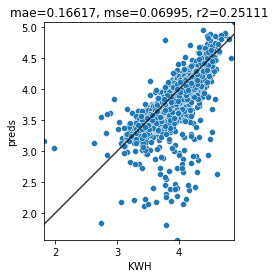

mae = 0.1661743875279335
mse = 0.06995128021957493
r2_score = 0.2511054040623697


In [636]:
y_preds2=model_deep.predict(X_test)

preds=[]
for i in y_preds2:
    for j in i:
        preds.append(j)
        
model_mae2=mean_absolute_error(y_test,y_preds2)
sns.scatterplot(x=y_test, y=preds) 

ax2 = plt.gca()
ax2.set_aspect('equal')
ax2.set_xlim([min(y_test), max(y_test)])
ax2.set_ylim([min(y_preds2), max(y_preds2)])
lims2 = [
    np.min([ax2.get_xlim(), ax2.get_ylim()]),  # min of both axes
    np.max([ax2.get_xlim(), ax2.get_ylim()]),  # max of both axes
]

ax2.plot(lims2, lims2, 'k-', alpha=0.75, zorder=2)
# plt.axhline(y=0, color='r', linestyle='-')
plt.ylabel('preds')
plt.title(f"mae={model_mae2:.5f}, " +
          f"mse={mean_squared_error(y_test, y_preds2):.5f}, " +
          f"r2={r2_score(y_test, y_preds2):.5f}")

plt.show() 

print(f"mae = {model_mae2}")
print(f"mse = {mean_squared_error(y_test, y_preds2)}")
print(f"r2_score = {r2_score(y_test, y_preds2)}")

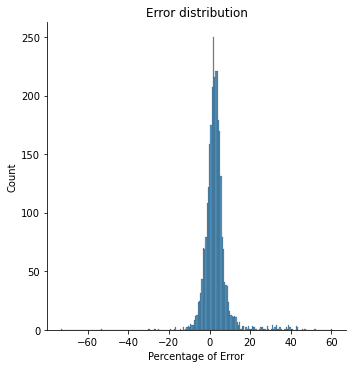

In [642]:
#Percentage error for actual vs predicted value
preds_percent_diff2 = (y_test - preds).div(y_test, axis=0)*100
sns.displot(preds_percent_diff2)
plt.xlabel("Percentage of Error")
plt.title('Error distribution')
plt.show()

In [638]:
preds_percent_diff2.sum()

8691.118675551403

As you can see, in order to investigate whether the model performance is good or not. We not only look at some metrics (MSE,MAE,or R^2), but we also plot their error distribution. The error distribution can indicate how likely each error delta is. More predictions remain consistently and more symmetrical at 0%, the better the model performance.

From the above 3 error distributions, it is clear that the xgboost performs the best. The summation of the percentage of error should be as less as possible. The absolute percentage of error of xgboost is the least at 18%.

Even though we have our regression model, we need a way to understand how accurate our model is predicting. One thing we would like to tackle is the uncertainty of an actual, singular prediction. While metrics like the model fit or a loss function can tell us how well the model is generally doing, we would like to see how that translates for a single data point. Why we might do that is due to the fact that not all predictions are made equal. Our model may be very sure of the KWH value of one data point, but significantly less in others. We can now create a prediction interval to see if it can capture most of the variations for model predictions on our data points.

## 5. Error Analysis <a class="anchor" id="EA"></a>

Creating prediction intervals to see whether each actual KWH falls in the prediction interval or not.

We take out the last 1,200 (10%) data points as the hold-out set (testing data that could not be seen during training or validation). Then we split other data into 75% of training and 25% of validation. Next, we run the model with those randomized training and validation sets and then feed in our test set for a set of predictions on their log KWH.

In [700]:
#10% of hold-out set
X_test_a=X_[-1200:]
y_test_a=y[-1200:]

### 5.1 Random Forest

In [708]:
preds_df_r=pd.DataFrame()

for i in range(3):
    X_train_r, X_val_r, y_train_r, y_val_r = train_test_split(X_[:-1200],y[:-1200],test_size=0.25, random_state = i)
    print(i)
    rd_regressor_r=RandomForestRegressor(random_state=100,n_jobs=-1,verbose=True)
    rd_regressor_r.fit(X_train_r,y_train_r)
    rd_regressor_preds_r=rd_regressor_r.predict(X_test_a)
    preds_df_r[i]=rd_regressor_preds_r

0


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    9.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   26.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


1


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   28.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


2


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   11.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   29.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


In [709]:
preds_df_r['mean']=preds_df_r.iloc[:,0:2].mean(axis=1)
preds_df_r['std']=preds_df_r.iloc[:,0:2].std(axis=1)
preds_df_r['mean_minus_twostd']=preds_df_r['mean']-2*preds_df_r['std']
preds_df_r['mean_plus_twostd']=preds_df_r['mean']+2*preds_df_r['std']
preds_df_r

,0,1,2,mean,std,mean_minus_twostd,mean_plus_twostd
0,4.137184,4.131081,4.133712,4.134133,0.004315,4.125502,4.142763
1,4.145974,4.146817,4.135501,4.146396,0.000596,4.145203,4.147588
2,3.845884,3.821276,3.831606,3.833580,0.017401,3.798778,3.868382
3,4.135278,4.151045,4.151410,4.143161,0.011149,4.120863,4.165459
4,3.820091,3.824289,3.809302,3.822190,0.002969,3.816252,3.828127
...,...,...,...,...,...,...,...
1195,3.903257,3.906108,3.909898,3.904683,0.002016,3.900652,3.908714
1196,3.121772,3.115884,3.108350,3.118828,0.004164,3.110501,3.127155
1197,3.981269,3.988692,3.980865,3.984981,0.005249,3.974483,3.995478
1198,3.618802,3.629914,3.622880,3.624358,0.007858,3.608643,3.640073


In [710]:
y_test_a2=y_test_a.reset_index(drop=True)
preds_df_r['KWH']=y_test_a2
preds_df_r

,0,1,2,mean,std,mean_minus_twostd,mean_plus_twostd,KWH
0,4.137184,4.131081,4.133712,4.134133,0.004315,4.125502,4.142763,4.135387
1,4.145974,4.146817,4.135501,4.146396,0.000596,4.145203,4.147588,4.135641
2,3.845884,3.821276,3.831606,3.833580,0.017401,3.798778,3.868382,3.857453
3,4.135278,4.151045,4.151410,4.143161,0.011149,4.120863,4.165459,4.132932
4,3.820091,3.824289,3.809302,3.822190,0.002969,3.816252,3.828127,3.813047
...,...,...,...,...,...,...,...,...
1195,3.903257,3.906108,3.909898,3.904683,0.002016,3.900652,3.908714,3.883491
1196,3.121772,3.115884,3.108350,3.118828,0.004164,3.110501,3.127155,3.258398
1197,3.981269,3.988692,3.980865,3.984981,0.005249,3.974483,3.995478,3.992730
1198,3.618802,3.629914,3.622880,3.624358,0.007858,3.608643,3.640073,3.681241


In [705]:
#A function that detects if the actual KWH falls in the prediction interval
def capture(x,y,z):
    if z>=x and z<=y:
        return True
    else:
        return False

In [711]:
preds_df_r['capture']=preds_df_r.apply(lambda x: capture(x.mean_minus_twostd, x.mean_plus_twostd,x.KWH),axis=1)

In [712]:
preds_df_r['capture'].value_counts()

False    718
True     482
Name: capture, dtype: int64

There are 718 of 1,200 data points fall in the prediction interval, accounting for as much as 59.83%.

### 5.2 Xgboost

In [702]:
preds_df_x=pd.DataFrame()

for i in range(3):
    X_train_x, X_val_x, y_train_x, y_val_x = train_test_split(X_[:-1200],y[:-1200],test_size=0.25, random_state = i)
    print(i)
    dtrain_x=xgb.DMatrix(X_train_x,label=y_train_x)
    dval_x=xgb.DMatrix(X_val_x,label=y_val_x)
    dtest_x=xgb.DMatrix(X_test_a,label=y_test_a)
    model_x = xgb.train(
        params,
        dtrain_x,
        num_boost_round=num_boost_round,
        evals=[(dval_x, "Test")],
        early_stopping_rounds=10,
        verbose_eval = False,
    )
    y_preds_x=model_x.predict(dtest_x)
    preds_df_x[i]=y_preds_x

0
1
2


In [703]:
preds_df_x['mean']=preds_df_x.iloc[:,0:2].mean(axis=1)
preds_df_x['std']=preds_df_x.iloc[:,0:2].std(axis=1)
preds_df_x['mean_minus_twostd']=preds_df_x['mean']-2*preds_df_x['std']
preds_df_x['mean_plus_twostd']=preds_df_x['mean']+2*preds_df_x['std']
preds_df_x

,0,1,2,mean,std,mean_minus_twostd,mean_plus_twostd
0,4.138473,4.125863,4.122262,4.132168,0.008916,4.114336,4.150000
1,4.134640,4.122391,4.127924,4.128515,0.008661,4.111193,4.145838
2,3.858736,3.857485,3.868393,3.858110,0.000885,3.856341,3.859880
3,4.142399,4.122742,4.115053,4.132571,0.013900,4.104771,4.160370
4,3.817458,3.829333,3.818600,3.823396,0.008397,3.806602,3.840189
...,...,...,...,...,...,...,...
1195,3.880574,3.876267,3.887876,3.878420,0.003045,3.872329,3.884511
1196,3.206178,3.212509,3.203505,3.209343,0.004477,3.200389,3.218297
1197,3.995312,3.997482,3.989203,3.996397,0.001535,3.993327,3.999467
1198,3.681616,3.660988,3.665818,3.671302,0.014586,3.642130,3.700475


In [704]:
y_test_a1=y_test_a.reset_index(drop=True)
preds_df_x['KWH']=y_test_a1
preds_df_x

,0,1,2,mean,std,mean_minus_twostd,mean_plus_twostd,KWH
0,4.138473,4.125863,4.122262,4.132168,0.008916,4.114336,4.150000,4.135387
1,4.134640,4.122391,4.127924,4.128515,0.008661,4.111193,4.145838,4.135641
2,3.858736,3.857485,3.868393,3.858110,0.000885,3.856341,3.859880,3.857453
3,4.142399,4.122742,4.115053,4.132571,0.013900,4.104771,4.160370,4.132932
4,3.817458,3.829333,3.818600,3.823396,0.008397,3.806602,3.840189,3.813047
...,...,...,...,...,...,...,...,...
1195,3.880574,3.876267,3.887876,3.878420,0.003045,3.872329,3.884511,3.883491
1196,3.206178,3.212509,3.203505,3.209343,0.004477,3.200389,3.218297,3.258398
1197,3.995312,3.997482,3.989203,3.996397,0.001535,3.993327,3.999467,3.992730
1198,3.681616,3.660988,3.665818,3.671302,0.014586,3.642130,3.700475,3.681241


In [706]:
preds_df_x['capture']=preds_df_x.apply(lambda x: capture(x.mean_minus_twostd, x.mean_plus_twostd,x.KWH),axis=1)

In [707]:
preds_df_x['capture'].value_counts()

True     715
False    485
Name: capture, dtype: int64

There are 715 of 1,200 data points fall in the prediction interval, accounting for as much as 59.58%.

### 5.3 Deep learning

In [723]:
preds_df_d=pd.DataFrame()

for i in range(3):
    X_train_d, X_val_d, y_train_d, y_val_d = train_test_split(X_[:-1200],y[:-1200],test_size=0.25, random_state = i)
    print(i)
    model_deep_d=keras.Sequential()
    model_deep_d.add(layers.Dense(512, activation="relu"))
    model_deep_d.add(layers.Dense(128, activation="relu"))
    model_deep_d.add(layers.Dense(64, activation="relu"))
    model_deep_d.add(layers.Dense(1))
    model_deep_d.compile(loss=keras.losses.mean_squared_error,optimizer=keras.optimizers.RMSprop(0.001))
    history_d=model_deep_d.fit(X_train_d,y_train_d,batch_size=32,epochs=20)
    y_preds_d=model_deep_d.predict(X_test_a)
    preds_df_d[i]=y_preds_d[:,0]

0
Epoch 1/20
256/256 [==============================] - 2s 7ms/step - loss: 0.5175
Epoch 2/20
256/256 [==============================] - 2s 7ms/step - loss: 0.2261
Epoch 3/20
256/256 [==============================] - 2s 7ms/step - loss: 0.1512
Epoch 4/20
256/256 [==============================] - 2s 7ms/step - loss: 0.1491
Epoch 5/20
256/256 [==============================] - 2s 7ms/step - loss: 0.1125
Epoch 6/20
256/256 [==============================] - 2s 7ms/step - loss: 0.0837
Epoch 7/20
256/256 [==============================] - 2s 7ms/step - loss: 0.0701
Epoch 8/20
256/256 [==============================] - 2s 7ms/step - loss: 0.0658
Epoch 9/20
256/256 [==============================] - 2s 7ms/step - loss: 0.0619
Epoch 10/20
256/256 [==============================] - 2s 7ms/step - loss: 0.0505
Epoch 11/20
256/256 [==============================] - 2s 8ms/step - loss: 0.0431
Epoch 12/20
256/256 [==============================] - 2s 7ms/step - loss: 0.0391
Epoch 13/20
256/256 [==

In [724]:
preds_df_d['mean']=preds_df_d.iloc[:,0:2].mean(axis=1)
preds_df_d['std']=preds_df_d.iloc[:,0:2].std(axis=1)
preds_df_d['mean_minus_twostd']=preds_df_d['mean']-2*preds_df_d['std']
preds_df_d['mean_plus_twostd']=preds_df_d['mean']+2*preds_df_d['std']
preds_df_d

,0,1,2,mean,std,mean_minus_twostd,mean_plus_twostd
0,3.719850,4.007314,4.280640,3.863582,0.203268,3.457046,4.270118
1,3.939083,4.027972,4.153179,3.983527,0.062854,3.857819,4.109235
2,3.466908,3.627081,3.856852,3.546994,0.113260,3.320474,3.773514
3,3.836067,4.080332,4.395957,3.958200,0.172722,3.612756,4.303643
4,3.525062,3.500840,3.978957,3.512951,0.017127,3.478696,3.547205
...,...,...,...,...,...,...,...
1195,3.637475,3.565339,3.925123,3.601407,0.051008,3.499391,3.703422
1196,2.915918,3.303417,3.694381,3.109668,0.274003,2.561662,3.657673
1197,3.679420,3.501442,3.898444,3.590431,0.125850,3.338732,3.842130
1198,3.184772,3.112220,3.697191,3.148496,0.051302,3.045893,3.251099


In [725]:
y_test_a3=y_test_a.reset_index(drop=True)
preds_df_d['KWH']=y_test_a3
preds_df_d

,0,1,2,mean,std,mean_minus_twostd,mean_plus_twostd,KWH
0,3.719850,4.007314,4.280640,3.863582,0.203268,3.457046,4.270118,4.135387
1,3.939083,4.027972,4.153179,3.983527,0.062854,3.857819,4.109235,4.135641
2,3.466908,3.627081,3.856852,3.546994,0.113260,3.320474,3.773514,3.857453
3,3.836067,4.080332,4.395957,3.958200,0.172722,3.612756,4.303643,4.132932
4,3.525062,3.500840,3.978957,3.512951,0.017127,3.478696,3.547205,3.813047
...,...,...,...,...,...,...,...,...
1195,3.637475,3.565339,3.925123,3.601407,0.051008,3.499391,3.703422,3.883491
1196,2.915918,3.303417,3.694381,3.109668,0.274003,2.561662,3.657673,3.258398
1197,3.679420,3.501442,3.898444,3.590431,0.125850,3.338732,3.842130,3.992730
1198,3.184772,3.112220,3.697191,3.148496,0.051302,3.045893,3.251099,3.681241


In [726]:
preds_df_d['capture']=preds_df_d.apply(lambda x: capture(x.mean_minus_twostd, x.mean_plus_twostd,x.KWH),axis=1)

In [727]:
preds_df_d['capture'].value_counts()

False    602
True     598
Name: capture, dtype: int64

There are 602 of 1,200 data points fall in the prediction interval, accounting for as much as 50.17%.

From the prediction interval results, we can conclude that random forest is the dominant choice with almost 60% of accuracy, which is followed by the Xgboost. Deep learning is again the third place with only 50%.

## 6. Conclusion <a class="anchor" id="CN"></a>

We pre-processed the data and split the data into 75% for training and 25% for testing, then trained the model and tuned hyperparameters by k-fold validation, which was followed by comparing the model performance among random forest, xgboost and deep learning algorithms by looking at the R^2, MAE, MSE metrics.

All in all, if we have a data set that includes many housing characteristics and would like to predict its energy consumption, we may as well try using Xgboost or random forest algorithm since they behave well in both performance metrics and the practical situation.

## 7. Next steps <a class="anchor" id="NS"></a>

In order to further improve the model performance, our next step is to contact SMEs (Subject Matter Experts), who can use their experience to identify and engineer new features (e.g., transformation or combination of some important features, different regions, etc.). We also recommend the user input on modeling and error analysis to check whether our results are consistent with their business experience and intuition.